# 📘 Notebook 1: Vector Search Indexing

## What is Indexing in a Vector Database?

When you store millions of vectors (embeddings) in a database, finding the nearest neighbors to a query vector requires comparing it against **every single vector**. This is called **brute-force search** — it's accurate but painfully slow.

**Indexing** solves this by organizing vectors into a structure that allows us to **skip most comparisons** and only look at a small subset of the data. The most popular indexing method is **IVF (Inverted File Index)**.

---

### What we'll cover:

| Section | Topic | Key Insight |
|---------|-------|-------------|
| **Part 1** | Brute-Force Search | The baseline — exact, but scans everything |
| **Part 2** | IVF (Inverted File) Index | Cluster vectors → search only relevant clusters |

### Key terms:
- **KNN (K-Nearest Neighbors)**: Finding the K most similar vectors to a query
- **Recall@K**: What fraction of the *true* K nearest neighbors did our method find? (1.0 = perfect)
- **ANN (Approximate Nearest Neighbor)**: Trading a small amount of accuracy for a large speed gain

---

Let's start by setting up our data!

## 🛠 Setup & Data Generation

We'll generate **200,000 synthetic vectors** in 128 dimensions. To make the data realistic (not purely random), we create **50 clusters** — similar to how real embeddings form natural groupings (e.g., topics in text, categories in images).

In [1]:
import lancedb
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import time
import shutil
import os
import warnings
warnings.filterwarnings('ignore')

print(f"LanceDB version: {lancedb.__version__}")
print(f"NumPy version:   {np.__version__}")

/Users/raghunandana.sanur/Desktop/test-repo/vector-db-interals/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


LanceDB version: 0.27.1
NumPy version:   2.0.2


In [2]:
# ── Configuration ──────────────────────────────────────────────
NUM_VECTORS = 200_000      # Total vectors in the database
DIMENSION   = 128          # Dimensionality of each vector
TOP_K       = 10           # Number of nearest neighbors to retrieve
NUM_QUERIES = 50           # Number of queries to average over
DB_PATH     = "./demo_lancedb_indexing"  # Where LanceDB stores data
SEED        = 42           # For reproducibility

np.random.seed(SEED)
print(f"✅ Config: {NUM_VECTORS:,} vectors × {DIMENSION}D, Top-{TOP_K} search, {NUM_QUERIES} query trials")

✅ Config: 200,000 vectors × 128D, Top-10 search, 50 query trials


### Why clustered data?

Real-world embeddings aren't uniformly random — they form **natural clusters**. For example:
- Text embeddings: documents about "sports" cluster together, "finance" clusters elsewhere
- Image embeddings: photos of cats are closer to each other than to photos of cars

We simulate this by generating vectors around **50 cluster centers** with Gaussian noise.

In [3]:
# ── Generate synthetic clustered vectors ──────────────────────
NUM_CLUSTERS = 50
vectors_per_cluster = NUM_VECTORS // NUM_CLUSTERS

# Create cluster centers spread out in the vector space
centers = np.random.randn(NUM_CLUSTERS, DIMENSION).astype(np.float32) * 5

# Generate vectors around each center with Gaussian noise
all_vectors = []
for center in centers:
    cluster_vecs = center + np.random.randn(vectors_per_cluster, DIMENSION).astype(np.float32) * 0.5
    all_vectors.append(cluster_vecs)

vectors = np.vstack(all_vectors)
np.random.shuffle(vectors)  # Shuffle so clusters aren't contiguous in storage

print(f"✅ Generated {vectors.shape[0]:,} vectors of dimension {vectors.shape[1]}")
print(f"   Arranged in {NUM_CLUSTERS} clusters, ~{vectors_per_cluster:,} vectors each")
print(f"   Memory footprint: {vectors.nbytes / 1024**2:.1f} MB (raw float32)")

✅ Generated 200,000 vectors of dimension 128
   Arranged in 50 clusters, ~4,000 vectors each
   Memory footprint: 97.7 MB (raw float32)


In [4]:
# ── Generate query vectors (from the same distribution) ──────
# Queries come from the same clusters — simulating a user searching
# for something similar to existing data
query_vectors = []
for _ in range(NUM_QUERIES):
    center = centers[np.random.randint(NUM_CLUSTERS)]
    q = center + np.random.randn(DIMENSION).astype(np.float32) * 0.5
    query_vectors.append(q)

query_vectors = np.array(query_vectors)
print(f"✅ Generated {NUM_QUERIES} query vectors")

✅ Generated 50 query vectors


In [5]:
# ── Load data into LanceDB ────────────────────────────────────
if os.path.exists(DB_PATH):
    shutil.rmtree(DB_PATH)

db = lancedb.connect(DB_PATH)

data = pa.table({
    "id":     pa.array(range(NUM_VECTORS), type=pa.int64()),
    "vector": pa.FixedSizeListArray.from_arrays(
                  pa.array(vectors.flatten(), type=pa.float32()),
                  list_size=DIMENSION
              )
})

tbl = db.create_table("vectors", data)
print(f"✅ Created LanceDB table with {tbl.count_rows():,} rows")
print(f"   Schema: {tbl.schema}")

✅ Created LanceDB table with 200,000 rows
   Schema: id: int64
vector: fixed_size_list<item: float>[128]
  child 0, item: float


---
## 🧰 Helper Functions

Before benchmarking, let's define helper functions. Here's what each one does:

| Function | Purpose |
|----------|--------|
| `brute_force_knn()` | Computes exact nearest neighbors using NumPy — this is our **ground truth** (the "correct answer") |
| `compute_ground_truth()` | Runs `brute_force_knn()` for all queries and caches the results |
| `recall_at_k()` | Measures **accuracy**: what fraction of the true Top-K neighbors did an approximate method actually find? |
| `benchmark_search()` | Runs a LanceDB search with given settings and measures both **speed** (query time) and **accuracy** (recall) |

### What is Recall?

**Recall@K** is THE key metric for approximate nearest neighbor search:

```
                   |  neighbors found by ANN  ∩  true neighbors  |
Recall@K  =  ──────────────────────────────────────────────────────
                              K  (total true neighbors)
```

- **Recall = 1.0 (100%)**: The approximate method found ALL the correct neighbors ✅
- **Recall = 0.8 (80%)**: It found 8 out of 10 correct neighbors — missed 2 ⚠️
- **Recall = 0.0 (0%)**: It found NONE of the correct neighbors ❌

In [6]:
def brute_force_knn(vectors, query, k):
    """
    Exact K-Nearest Neighbors using NumPy.
    
    How it works:
    1. Compute the L2 (Euclidean) distance from the query to EVERY vector
    2. Find the K smallest distances
    3. Return their indices
    
    This is O(N) — we must touch every vector. That's the problem indexing solves.
    """
    dists = np.sum((vectors - query) ** 2, axis=1)  # L2 squared distance
    top_k_idx = np.argpartition(dists, k)[:k]       # Partial sort (faster than full sort)
    top_k_idx = top_k_idx[np.argsort(dists[top_k_idx])]  # Sort the top-k by distance
    return set(top_k_idx)


def compute_ground_truth(vectors, query_vectors, k):
    """
    Compute the exact nearest neighbors for ALL queries.
    
    We do this once upfront so we can measure how "accurate" our
    approximate methods are by comparing their results to this ground truth.
    """
    ground_truth = []
    for q in query_vectors:
        gt = brute_force_knn(vectors, q, k)
        ground_truth.append(gt)
    return ground_truth


def recall_at_k(retrieved_ids, ground_truth_ids):
    """
    Calculate recall: what fraction of the true neighbors did we find?
    
    Example:
      True neighbors:      {10, 20, 30, 40, 50}  (5 total)
      Retrieved neighbors:  {10, 20, 30, 42, 55}  (5 total)
      Intersection:         {10, 20, 30}           (3 matches)
      Recall = 3/5 = 0.6
    """
    return len(retrieved_ids & ground_truth_ids) / len(ground_truth_ids)


def benchmark_search(table, query_vectors, ground_truth, k, nprobes=None, 
                     refine_factor=None, use_index=True):
    """
    Benchmark a LanceDB search configuration.
    
    Returns:
      - avg_time_ms: average query latency in milliseconds
      - p95_time_ms: 95th percentile latency (worst-case-ish)
      - avg_recall:  average recall across all queries
      - min_recall:  worst recall among all queries
    
    Parameters:
      - nprobes:        How many IVF partitions to search (more = slower but higher recall)
      - refine_factor:  Re-rank top results using original vectors (improves recall after quantization)
      - use_index:      If False, bypasses the index entirely (brute force through LanceDB)
    """
    times = []
    recalls = []
    
    for i, q in enumerate(query_vectors):
        query_builder = table.search(q.tolist()).limit(k).metric("L2")
        
        if not use_index:
            query_builder = query_builder.bypass_vector_index()
        if nprobes is not None:
            query_builder = query_builder.nprobes(nprobes)
        if refine_factor is not None:
            query_builder = query_builder.refine_factor(refine_factor)
        
        start = time.perf_counter()
        results = query_builder.to_pandas()
        elapsed = time.perf_counter() - start
        
        times.append(elapsed)
        retrieved_ids = set(results["id"].tolist())
        recalls.append(recall_at_k(retrieved_ids, ground_truth[i]))
    
    return {
        "avg_time_ms": np.mean(times) * 1000,
        "p95_time_ms": np.percentile(times, 95) * 1000,
        "avg_recall":  np.mean(recalls),
        "min_recall":  np.min(recalls),
    }

print("✅ Helper functions defined")

✅ Helper functions defined


In [7]:
# ── Compute ground truth ─────────────────────────────────────
print("⏳ Computing ground truth (exact KNN for all queries)...")
print("   This uses brute-force NumPy — every query compares against all 200K vectors.\n")

start = time.time()
ground_truth = compute_ground_truth(vectors, query_vectors, TOP_K)
gt_time = time.time() - start

print(f"✅ Ground truth computed in {gt_time:.2f}s")
print(f"   We now know the TRUE {TOP_K} nearest neighbors for each query.")
print(f"   Everything below will be compared against this.")

⏳ Computing ground truth (exact KNN for all queries)...
   This uses brute-force NumPy — every query compares against all 200K vectors.

✅ Ground truth computed in 0.89s
   We now know the TRUE 10 nearest neighbors for each query.
   Everything below will be compared against this.


---
## Part 1 — Brute-Force Search (The Baseline) 🐢

### How brute-force search works:

```
┌────────────────────────────────────────────────────────┐
│                                                        │
│   Query Vector  ──→  Compare with ALL 200,000 vectors  │
│                  ──→  Sort by distance                  │
│                  ──→  Return Top-10                     │
│                                                        │
│   Comparisons: 200,000  ✓ exact  ✗ slow                │
└────────────────────────────────────────────────────────┘
```

**Pros:**
- 100% accurate — guaranteed to find the true nearest neighbors
- Simple — no preprocessing needed

**Cons:**
- **O(N)** per query — query time grows linearly with data size
- At 1 million vectors, it's ~5× slower. At 1 billion, it's unusable.

> **Analogy:** Imagine finding the closest coffee shop by walking to *every single coffee shop in the city* and measuring the distance. Accurate, but you'd be walking all day! ☕🚶

In [8]:
# ── Brute-force search through LanceDB (no index) ────────────
print("🔍 Running brute-force search (no index)...")
print(f"   Each query scans all {NUM_VECTORS:,} vectors.\n")

bf_results = benchmark_search(tbl, query_vectors, ground_truth, TOP_K, use_index=False)

print(f"  ⏱  Avg query time:  {bf_results['avg_time_ms']:.2f} ms")
print(f"  ⏱  P95 query time:  {bf_results['p95_time_ms']:.2f} ms")
print(f"  🎯 Avg Recall@{TOP_K}:  {bf_results['avg_recall']:.4f}  ({bf_results['avg_recall']*100:.0f}%)")
print(f"  🎯 Min Recall@{TOP_K}:  {bf_results['min_recall']:.4f}")
print(f"\n💡 Recall is {bf_results['avg_recall']*100:.0f}% — brute force always finds the exact answers.")
print(f"   But {bf_results['avg_time_ms']:.1f} ms per query adds up fast at scale!")

🔍 Running brute-force search (no index)...
   Each query scans all 200,000 vectors.

  ⏱  Avg query time:  15.15 ms
  ⏱  P95 query time:  16.71 ms
  🎯 Avg Recall@10:  1.0000  (100%)
  🎯 Min Recall@10:  1.0000

💡 Recall is 100% — brute force always finds the exact answers.
   But 15.1 ms per query adds up fast at scale!


### 🤔 Why is brute-force a problem at scale?

Let's do the math for a production system:

| Vectors | Query Time (est.) | Queries/sec | Feasible? |
|---------|-------------------|-----------|----------|
| 200K    | ~15 ms           | ~66 QPS   | Maybe ⚠️  |
| 1M      | ~75 ms           | ~13 QPS   | Slow 🐢   |
| 10M     | ~750 ms          | ~1 QPS    | No ❌     |
| 100M    | ~7.5 sec         | < 1 QPS   | No ❌     |

This is why we need **indexing** — let's see how IVF solves this!

---
## Part 2 — IVF (Inverted File) Index ⚡

### The Core Idea

Instead of searching ALL vectors, **group them into clusters** and **only search the relevant clusters**.

```
   TRAINING PHASE (one-time):
   ┌────────────────────────────────────────────────────┐
   │                                                    │
   │   200K vectors  ──→  K-Means clustering            │
   │                  ──→  64 clusters (partitions)      │
   │                  ──→  Each cluster has a centroid    │
   │                                                    │
   └────────────────────────────────────────────────────┘

   SEARCH PHASE (per query):
   ┌────────────────────────────────────────────────────┐
   │                                                    │
   │   Query ──→  Compare with 64 centroids (FAST!)     │
   │          ──→  Pick closest `nprobes` clusters       │
   │          ──→  Search only vectors in those clusters │
   │          ──→  Return Top-K                         │
   │                                                    │
   │   With nprobes=5: search ~5/64 = 8% of data!      │
   └────────────────────────────────────────────────────┘
```

### The `nprobes` parameter

This is the **key knob** that controls the speed ↔ recall tradeoff:

| nprobes | Vectors searched | Speed | Recall |
|---------|-----------------|-------|--------|
| 1       | ~3,125 (1/64)   | ⚡⚡⚡ | Lower  |
| 5       | ~15,625 (5/64)  | ⚡⚡   | Good   |
| 20      | ~62,500 (20/64) | ⚡     | Great  |
| 64      | 200,000 (all)   | 🐢    | Perfect (= brute force) |

> **Analogy:** Instead of checking every coffee shop in the city, you first look at a map divided into neighborhoods. You then only visit the 2–3 neighborhoods closest to you. You *might* miss a coffee shop right on the border, but you save a ton of walking! 🗺️☕

In [9]:
# ── Build an IVF_FLAT index ──────────────────────────────────
# IVF_FLAT = IVF partitioning WITHOUT any vector compression
# The vectors are stored in full float32 precision within each partition

NUM_PARTITIONS = 64  # Number of clusters

print(f"🏗️  Building IVF_FLAT index...")
print(f"   Partitions: {NUM_PARTITIONS}")
print(f"   Avg vectors per partition: ~{NUM_VECTORS // NUM_PARTITIONS:,}")
print(f"   Algorithm: K-Means clustering on {NUM_VECTORS:,} vectors\n")

start = time.time()
tbl.create_index(
    metric="L2",
    num_partitions=NUM_PARTITIONS,
    index_type="IVF_FLAT",
    replace=True
)
build_time = time.time() - start

print(f"✅ IVF_FLAT index built in {build_time:.2f}s")
print(f"   The index has organized {NUM_VECTORS:,} vectors into {NUM_PARTITIONS} partitions.")

🏗️  Building IVF_FLAT index...
   Partitions: 64
   Avg vectors per partition: ~3,125
   Algorithm: K-Means clustering on 200,000 vectors

✅ IVF_FLAT index built in 0.28s
   The index has organized 200,000 vectors into 64 partitions.


### Let's see `nprobes` in action!

We'll search with different `nprobes` values and measure both **speed** and **recall**. Watch how the tradeoff works:

In [10]:
# ── Benchmark IVF with varying nprobes ───────────────────────
nprobe_values = [1, 2, 5, 10, 20, 50]
ivf_results = {}

print(f"🔍 Benchmarking IVF_FLAT with different nprobes values...")
print(f"   ({NUM_QUERIES} queries per setting, averaged)\n")
print(f"{'nprobes':<10} {'% Data Searched':<18} {'Avg Time (ms)':<18} {'Recall@'+str(TOP_K):<15} {'Speedup vs BF':<15}")
print("─" * 78)

for np_val in nprobe_values:
    result = benchmark_search(tbl, query_vectors, ground_truth, TOP_K, nprobes=np_val)
    ivf_results[np_val] = result
    pct_searched = (np_val / NUM_PARTITIONS) * 100
    speedup = bf_results['avg_time_ms'] / result['avg_time_ms']
    print(f"{np_val:<10} {pct_searched:<18.1f} {result['avg_time_ms']:<18.2f} {result['avg_recall']:<15.4f} {speedup:<15.1f}x")

print(f"\n💡 Observations:")
print(f"   • nprobes=1 searches only {100/NUM_PARTITIONS:.1f}% of data — fast but misses some neighbors")
print(f"   • nprobes=20 searches {20/NUM_PARTITIONS*100:.0f}% of data — nearly perfect recall with huge speedup")
print(f"   • The jump from nprobes=1 → 5 gives the biggest recall improvement!")

🔍 Benchmarking IVF_FLAT with different nprobes values...
   (50 queries per setting, averaged)

nprobes    % Data Searched    Avg Time (ms)      Recall@10       Speedup vs BF  
──────────────────────────────────────────────────────────────────────────────
1          1.6                1.39               0.8900          10.9           x
2          3.1                1.03               0.9840          14.7           x
5          7.8                1.07               1.0000          14.1           x
10         15.6               1.36               1.0000          11.1           x
20         31.2               1.48               1.0000          10.2           x
50         78.1               1.90               1.0000          8.0            x

💡 Observations:
   • nprobes=1 searches only 1.6% of data — fast but misses some neighbors
   • nprobes=20 searches 31% of data — nearly perfect recall with huge speedup
   • The jump from nprobes=1 → 5 gives the biggest recall improvement!


### 📊 Visualizing the Tradeoff

The two charts below show the fundamental tradeoff that indexing introduces:

1. **Left**: As we increase `nprobes`, recall improves (we find more true neighbors)
2. **Right**: As we increase `nprobes`, query time also increases (we search more data)

The sweet spot is where the recall curve **flattens out** — beyond that point, extra probes cost time but barely help accuracy.

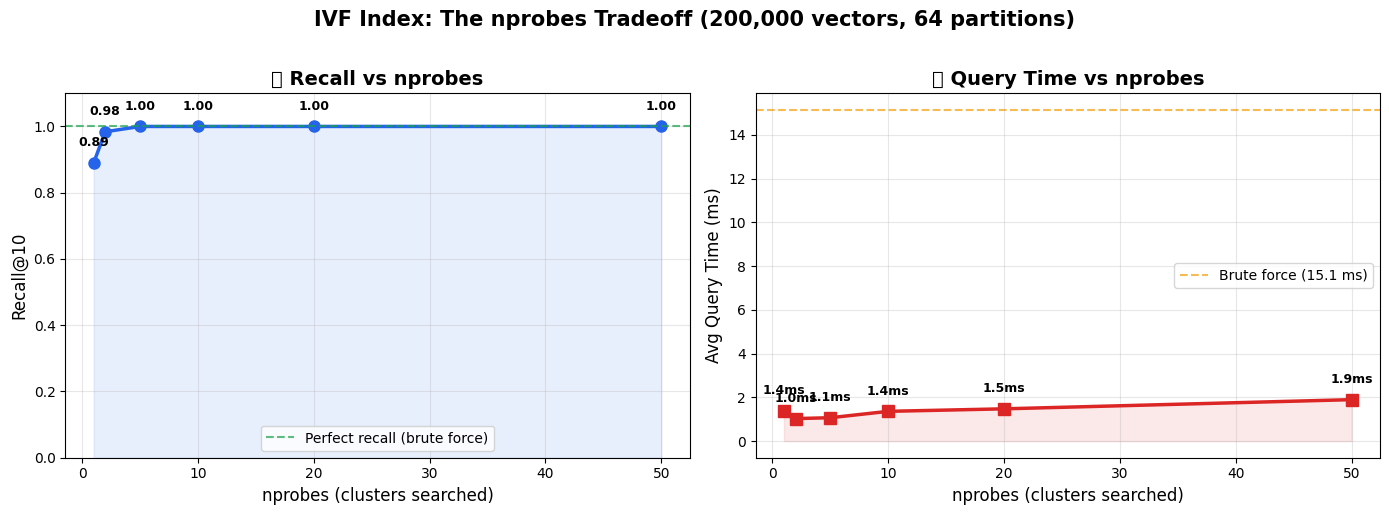

In [11]:
# ── Visualization: The nprobes Tradeoff ──────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

nprobes_list = list(ivf_results.keys())
recalls      = [ivf_results[n]['avg_recall'] for n in nprobes_list]
times        = [ivf_results[n]['avg_time_ms'] for n in nprobes_list]

# ── Left chart: Recall vs nprobes ──
ax1.plot(nprobes_list, recalls, 'o-', color='#2563eb', linewidth=2.5, markersize=8)
ax1.axhline(y=1.0, color='#16a34a', linestyle='--', alpha=0.7, label='Perfect recall (brute force)')
ax1.fill_between(nprobes_list, recalls, alpha=0.1, color='#2563eb')
ax1.set_xlabel('nprobes (clusters searched)', fontsize=12)
ax1.set_ylabel(f'Recall@{TOP_K}', fontsize=12)
ax1.set_title('🎯 Recall vs nprobes', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.1)
ax1.grid(True, alpha=0.3)
for x, y in zip(nprobes_list, recalls):
    ax1.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 12),
                 fontsize=9, ha='center', fontweight='bold')

# ── Right chart: Query time vs nprobes ──
ax2.plot(nprobes_list, times, 's-', color='#dc2626', linewidth=2.5, markersize=8)
ax2.axhline(y=bf_results['avg_time_ms'], color='#f59e0b', linestyle='--', alpha=0.7,
            label=f'Brute force ({bf_results["avg_time_ms"]:.1f} ms)')
ax2.fill_between(nprobes_list, times, alpha=0.1, color='#dc2626')
ax2.set_xlabel('nprobes (clusters searched)', fontsize=12)
ax2.set_ylabel('Avg Query Time (ms)', fontsize=12)
ax2.set_title('⏱ Query Time vs nprobes', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
for x, y in zip(nprobes_list, times):
    ax2.annotate(f'{y:.1f}ms', (x, y), textcoords='offset points', xytext=(0, 12),
                 fontsize=9, ha='center', fontweight='bold')

plt.suptitle(f'IVF Index: The nprobes Tradeoff ({NUM_VECTORS:,} vectors, {NUM_PARTITIONS} partitions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

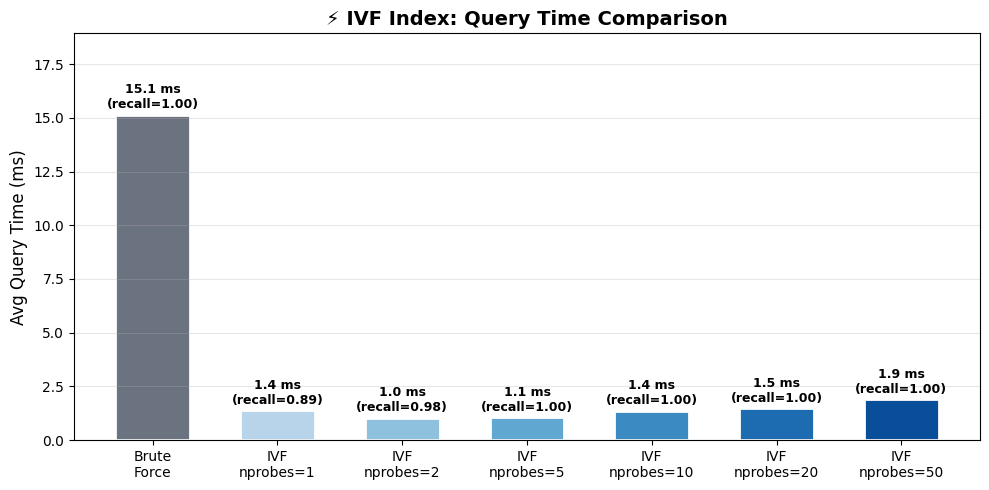


📌 KEY TAKEAWAYS FROM THIS NOTEBOOK:
   1. Brute-force search gives perfect recall but doesn't scale
   2. IVF indexing partitions vectors into clusters for faster search
   3. The 'nprobes' parameter is the speed ↔ recall knob
   4. In practice, nprobes=10-20 gives >95% recall with massive speedup

👉 Next: Notebook 2 explores how QUANTIZATION compresses vectors to save memory!


In [12]:
# ── Speedup comparison chart ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

methods = ['Brute\nForce'] + [f'IVF\nnprobes={n}' for n in nprobe_values]
all_times = [bf_results['avg_time_ms']] + times
all_recalls = [bf_results['avg_recall']] + recalls
colors = ['#6b7280'] + [plt.cm.Blues(0.3 + 0.7 * i/len(nprobe_values)) for i in range(len(nprobe_values))]

bars = ax.bar(methods, all_times, color=colors, edgecolor='white', linewidth=2, width=0.6)

for bar, t, r in zip(bars, all_times, all_recalls):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(all_times)*0.02,
            f'{t:.1f} ms\n(recall={r:.2f})', ha='center', fontsize=9, fontweight='bold')

ax.set_ylabel('Avg Query Time (ms)', fontsize=12)
ax.set_title('⚡ IVF Index: Query Time Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(all_times) * 1.25)
plt.tight_layout()
plt.show()

print("\n📌 KEY TAKEAWAYS FROM THIS NOTEBOOK:")
print("   1. Brute-force search gives perfect recall but doesn't scale")
print("   2. IVF indexing partitions vectors into clusters for faster search")
print("   3. The 'nprobes' parameter is the speed ↔ recall knob")
print("   4. In practice, nprobes=10-20 gives >95% recall with massive speedup")
print("\n👉 Next: Notebook 2 explores how QUANTIZATION compresses vectors to save memory!")